In [22]:
import pandas as pd 

In [23]:
df = pd.read_csv('C:/Users/i2max-DoeunKim/adps/ep5/ep5/m1_orders.csv')
nu = pd.read_csv('C:/Users/i2max-DoeunKim/adps/ep5/ep5/m1_nutrition.csv')

In [24]:
# df 처리 
df['Details'] = df['Details'].map(eval)
df['Extras'] = df['Extras'].fillna('[]').map(eval)

In [29]:
df1 = df.join(pd.DataFrame(df['Details'].tolist()))

In [32]:
df1['all'] = df1[['Menu','Extras','Bread','Cheese','Sauces']].\
apply(lambda x : [x['Menu']] + x['Extras'] + [x['Bread']] + [x['Cheese']] + x['Sauces'], axis = 1)

In [69]:
nu['kcal'] = nu['Carbohydrates(g)']*4 + nu['Protein(g)']*4 + nu['Fat(g)']*9

target = nu[['Item','kcal']].fillna('None')
# 딕셔너리 처리 
cal_dic = {}
for cate in target.Item.unique() : 
    t1 = target[target['Item'] == cate]
    for key, value in t1.values : 
        cal_dic[key] = value 

{'Wheat': 195.6,
 'Honey Oat': 235.0,
 'Hearty Italian': 210.5,
 'Parmesan Oregano': 208.5,
 'White': 198.0,
 'Flatbread': 236.0,
 'Turkey Breast': 224.2,
 'Veggie Delite': 203.7,
 'Tuna': 271.2,
 'Ham': 229.2,
 'Shrimp': 191.7,
 'Pulled Pork': 273.2,
 'Egg Mayo': 365.2,
 'B.L.T.': 243.2,
 'Roast Chicken': 262.2,
 'Subway Club': 245.7,
 'American Cheese': 32.5,
 'Shredded Cheese': 50.0,
 'Mozzarella': 39.0,
 'None': 0.0,
 'Red Wine Vinegar': 4.0,
 'Olive Oil': 45.0,
 'Sweet Chili': 40.5,
 'Honey Mustard': 60.0,
 'Sweet Onion': 76.5,
 'Mayonnaise': 114.0,
 'Ranch': 118.0,
 'Southwest Chipotle': 95.0,
 'Hot Chili': 49.0,
 'Horseradish': 99.0,
 'BBQ Sauce': 56.5,
 'Mustard': 14.5}

In [67]:
# price_dic 
price = nu[['Item','price']].dropna()

price_dic = {}
for item in price.Item.unique() : 
    t1 = price[price['Item'] == item]
    for key, value in t1.values : 
        price_dic[key] = value 

In [73]:
df1['cal'] = df1['all'].map(lambda x : sum([cal_dic[y] for y in x]))
df1['price'] = df1['all'].map(lambda x : sum([price_dic[y] for y in x if y in price_dic]))

<Axes: xlabel='OrderTime'>

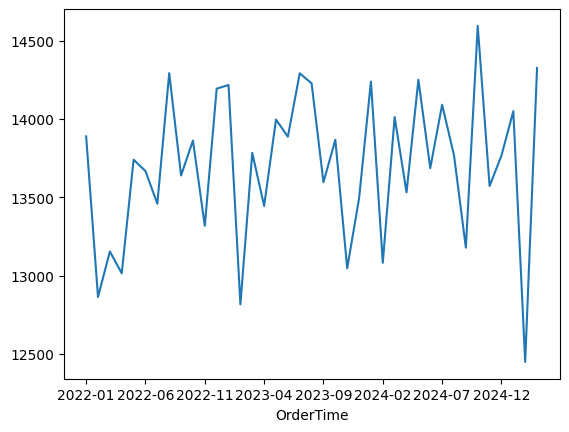

In [79]:
#df1[['OrderId','OrderTime','cal','price']]

df1['OrderTime'] = pd.to_datetime(df1['OrderTime'])
df1.groupby(df1['OrderTime'].dt.strftime('%Y-%m'))['price'].sum().plot()

In [87]:
df1['date'] = df1['OrderTime'].dt.date
y = df1[df1['OrderTime'].dt.hour >= 14].groupby('date')['price'].sum().reset_index() 
y.columns = ['date','y']

In [110]:
# 오전시간 
morning = df1[df1['OrderTime'].dt.hour < 14].reset_index(drop = True)
morning['Extras_counts'] = morning['Extras'].map(lambda x : 1 if len(x) >0 else 0)
morning['weekend']= morning['OrderTime'].dt.weekday.apply(lambda x : 1 if x >= 5 else 0)
morning['hour'] = morning['OrderTime'].dt.hour

In [115]:
agg_morning = morning.groupby('date').agg(sales_count = ('all','count') , 
                            total_price = ('price','sum') , 
                            weekend_flag = ('weekend', lambda x : x.unique()[0]), 
                            extra_total = ('Extras_counts' , 'sum'), 
                            Menu = ('Menu', lambda x : x.value_counts().values[0]), 
                            hour = ('hour', lambda x : x.value_counts().index[0])).sort_values('date').reset_index()

In [121]:
total_df = pd.merge(agg_morning, y , how = 'left', left_on = 'date', right_on = 'date')
total_df

,date,sales_count,total_price,weekend_flag,extra_total,Menu,hour,y
0,2022-01-01,23,144.26,1,0,5,11,272.92
1,2022-01-02,17,103.73,1,0,4,11,130.34
2,2022-01-03,30,198.57,0,3,5,13,306.25
3,2022-01-04,22,144.90,0,1,6,11,262.53
4,2022-01-05,25,172.15,0,3,4,13,332.70
...,...,...,...,...,...,...,...,...
1181,2025-03-27,27,177.83,0,1,8,12,318.15
1182,2025-03-28,37,242.07,0,1,8,12,389.69
1183,2025-03-29,22,144.05,1,2,5,11,156.44
1184,2025-03-30,23,158.77,1,2,4,12,176.43


In [123]:
#Lasso, svm, tree 계열 모델 3가지로 학습하고 결과 분석 rmse를 평가지표로 한다.
#grid search 진행

#test : 홀수 달의 18일 까지의 데이터
#train : 그것을 제외한 모든 데이
total_df['month'] = pd.to_datetime(total_df['date']).dt.month 
total_df['day']= pd.to_datetime(total_df['date']).dt.day

In [128]:
total_df['check'] = total_df.apply(lambda x : 'test' if (x['month']%2 == 1) & (x['day'] <= 18) else 'train', axis = 1)

train_set = total_df[total_df['check'] == 'train']
test_set = total_df[total_df['check'] == 'test']

In [162]:
x_train = train_set.drop(columns =['date', 'y', 'check'], axis = 1)
y_train = train_set['y']

x_test = test_set.drop(columns =['date', 'y', 'check'], axis = 1)
y_test = test_set['y']

In [165]:
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def eval_model(name, model, x_train, y_train, x_test, y_test) :
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

    return rmse 

res = []
for name, model in [['Lasso', Lasso()] , ['SVR', SVR()] , ['RF', RandomForestRegressor()]] : 
    rmse = eval_model(name, model, x_train, y_train, x_test, y_test)
    res.append([name, rmse])
    
result = pd.DataFrame(res, columns = ['Model', 'RMSE'])
result



,Model,RMSE
0,Lasso,54.701922
1,SVR,61.962314
2,RF,57.027668


한 고등학교의 수학 시험 점수는 평균 75점, 표준편차 8점인 정규분포를 따릅니다.

1. 80점 이상 받을 확률은?
2. 상위 10% 학생의 최소 점수는?

In [141]:
from scipy.stats import norm
import numpy as np 

x = 75 
s = 8 

# 1. 80점 이상 받을 확률 
prob80 = 1 - norm.cdf(80, x, s)
print(prob80)

# 2. 상위 10%에 해당하는 최소 점수 
z_90 = norm.ppf(0.9)
cutoff = x + z_90 * s 
print(cutoff)

0.26598552904870054
85.2524125243568


한 공장에서 생산된 전구의 불량률은 4% (p=0.04)입니다. 50개를 무작위로 검사합니다.

1. 정확히 3개가 불량일 확률은?
2. 5개 이상 불량일 확률은?

In [143]:
from scipy.stats import binom
p = 0.04 
n = 50 

rv = binom(n, p)
# 1) 
print(rv.pmf(3))

# 2) 
print(1 - rv.cdf(4))

0.18415520493576068
0.048971471884512785


한 커피숍에서 1시간 동안 평균 6건의 주문(λ=6)이 발생한다고 가정합니다.

1. 정확히 8건의 주문이 발생할 확률은?
2. 4건 이하의 주문이 발생할 확률은?

In [152]:
from scipy.stats import poisson, expon

lam = 6 

# 1) 8 
print(poisson.pmf(8, lam))

# 1) 4건 하하
print(poisson.cdf(4, lam))

0.1032577335308442
0.2850565003166312


한 은행 창구에서 고객이 평균 12분마다 도착한다고 가정합니다. </br>
다음 고객이 10분 이내에 도착할 확률은? 
$P(X \le 10) = 1 - e^{-\lambda \cdot 10}$ 

다음 고객이 20분 이상 걸릴 확률은? 
$P(X \ge 20) = e^{-\lambda \cdot 20}$

* 고객 도착은 불규칙하게 발생 > 평균적으로 12분 (포아송분포) > 도착 시간 간격(지수분포) 
* 지수 분포 : 다음 고객이 올 떄까지 걸리는 시간 

In [153]:
lam = 1/ 12 # 12분 마다 한명씩 
time = 1 / 12  # 12분 씩 대기 

# 1) 
print(1 - np.exp(1- time * 10))

# 2) 
print(np.exp(-time * 20))

-0.18136041286564608
0.18887560283756186


한 웹사이트의 광고 클릭률은 베타분포(α=15, β=85)를 따른다고 가정합니다 (평균 클릭률 ≈ 0.15)
1. 클릭률이 0.2 이상일 확률은?
2. 클릭률의 95% 신뢰구간(하위 2.5%, 상위 2.5%)은?

* [베타분포]
  확률값이 0~1 사이인 연속 확률 분포 X - Beta(a,B) 

In [155]:
from scipy.stats import beta 
a,b = 15, 85

# 1) 0.2 이상일 확률 
print(1 - beta.cdf(0.2, a, b))

# 2) 신뢰구간 
cr1 = beta.ppf(0.025 , a, b)
cr2 = beta.ppf(0.075, a, b)
print(cr1, cr2)

0.08765299019316353
0.08735483490895836 0.10152814861219413


한 병원에서 환자 4명을 진료하는 데 걸리는 시간이 감마분포(k=4, θ=5분)를 따른다고 가정합니다 (평균 20분).
1. 진료 시간이 15분 이내일 확률은?
2. 진료 시간이 30분 이상일 확률은?

In [158]:
from scipy import stats
k, theta = 4, 5  # 형상 k=4, 척도 θ=5 (평균 20분)

# 1. 15분 이내 확률
prob_15 = stats.gamma.cdf(x=15, a=k, scale=theta)
print(f"15분 이내 확률: {prob_15:.4f}")

# 2. 30분 이상 확률
prob_30_or_more = 1 - stats.gamma.cdf(x=30, a=k, scale=theta)
print(f"30분 이상 확률: {prob_30_or_more:.4f}")

15분 이내 확률: 0.3528
30분 이상 확률: 0.1512
